## Part 1 ‐ Exploratory data analysis

In [1]:
# Load json file
import pandas as pd

# Load the JSON file
login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
# Convert 'login_time' column to datetime and set it as the new index
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [3]:
# Check the shape
login_df.shape

(93142, 1)

In [4]:
# Check the uniqueness of 'login_time' column
len(login_df['login_time'].unique())

92265

In [5]:
# Find duplicates in this dataframe
duplicates = login_df.duplicated(subset = ['login_time'], keep = False)
duplicate_login = login_df[duplicates]
duplicate_login

,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
...,...
92439,1970-04-12 17:12:21
92984,1970-04-13 12:23:46
92986,1970-04-13 12:23:46
93021,1970-04-13 13:44:18


**There are duplicates in this dataset.**

In [6]:
# Drop dupicates
login_df = login_df.drop_duplicates(subset=['login_time'])
login_df.shape

(92265, 1)

In [7]:
# Check if there is any missing date in a month. It's highly unlikely there is no logins at all in a particular day.
# Generate a sequence of dates within the desired time frame
start_date = pd.to_datetime('1970-01-01')  
end_date = pd.to_datetime('1970-04-13')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Compare sequence of dates with dates in datetime_column
missing_date = set(date_range.date)-set(login_df['login_time'].dt.date)
missing_date

set()

**There is no missing date from 1970-01-01 to 1970-04-13.**

In [8]:
# Check if there is any default time 00:00:00 in a particular day.
default_time = pd.to_datetime('00:00:00').time()
login_df[login_df['login_time'].dt.time==default_time]

,login_time
32456,1970-02-15
37739,1970-02-21


**There are two entries with 00:00:00. However, it's hard to tell if they are misentries. We will keep them for now.**

<AxesSubplot: xlabel='login_time'>

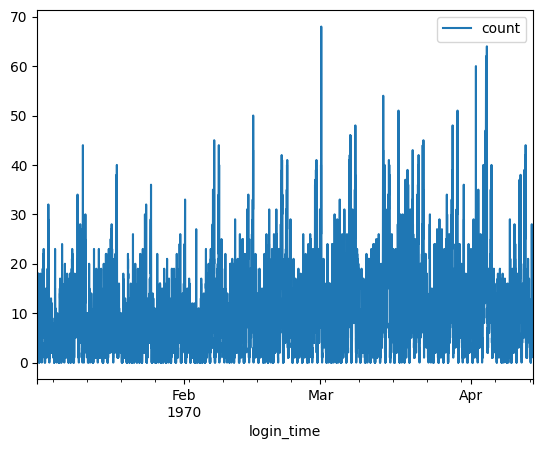

In [9]:
# Add a column of 'count'
login_df['count'] = 1

# Group by 15-minute intervals and sum the counts
result_15min = login_df.groupby(pd.Grouper(key='login_time', freq='15Min')).sum()
result_15min.plot()

**It seems that there was a weekly pattern in our data.**

In [10]:
result_15min.describe()

,count
count,9788.000000
mean,9.426338
std,8.172091
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,68.000000


<AxesSubplot: xlabel='login_time'>

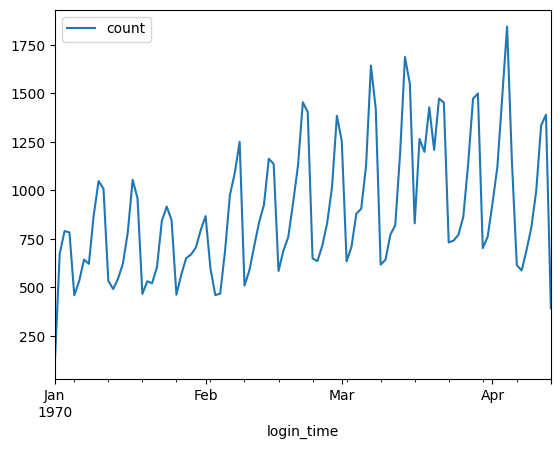

In [11]:
# Group by 24-hour intervals and sum the counts
result_day = login_df.groupby(pd.Grouper(key='login_time', freq='24H')).sum()
result_day.plot()

**There was a weekly seasonality repeated consistenly.**

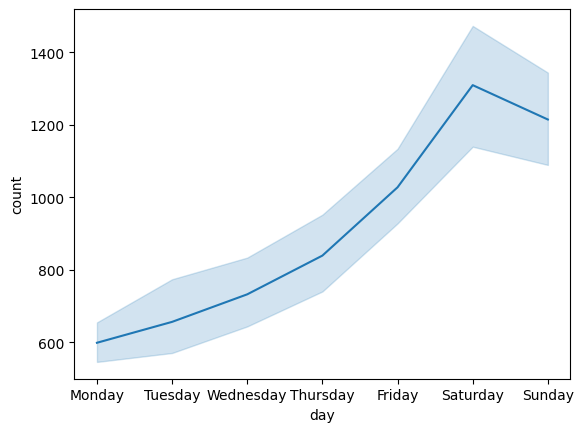

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column of 'day'
result_day['day'] = result_day.index.day_name()
result_day

# Select from Monday, 1970-01-05 to Sunday, 1970-04-10
start_date = '1970-01-05'
end_date = '1970-04-10'

selected_result_day = result_day[(result_day.index >= start_date) & (result_day.index <= end_date)]
_ = sns.lineplot(x=selected_result_day['day'], y =selected_result_day['count'])
plt.show()


**We can see that the demand was usaully the lowest on Monday and started to climb up from the beginning of every week. It generally reached the peak on Saturday, slightly declined on the following Sunday, and drastically dropped after the weekend.**

## Part 2 ‐ Experiment and metrics design

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

**I would choose the percentage of ride incurred in the neighboring city as the key measure of sucess. This measure is less likely to be compromised by outlier activities and can truly reflect if the experiment truly encourage driver partners to be available in both cities.**

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

**I would randomly select drivers from both cities. The sample size will depend on desired level of statistical power (e.q. β = 0.20), the effect size we want to detect, the variability of our data, and the chosen significance level (e.q. α = 0.05). Drivers will be randomized into two groups, one with the incentive reimbursement and the other without. We will run the experiment for at least a few weeks and dynamically verify the significance by conducting a hypothesis test, Independent t-test (Student's t-test). Based on the p value we will be able to tell if there is a significant differecne between the two groups. However, encouraging driver partners to serve both citie does not necessarily mean higher revenue. Since the two cities have complementary circadian rhythms, I will recommend that the Ultimate managers pay more attetion to the actual increase on rides in both cities and the long term effect after rolling out this promotion.**

## Part 3 ‐ Predictive modeling

In [13]:
# Load json file
import pandas as pd

# Load the JSON file with lines=True
user_df = pd.read_json('ultimate_data_challenge.json')
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
user_df.shape

(50000, 12)

In [15]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
user_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [17]:
user_df['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [18]:
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])
end_date = user_df['last_trip_date'].max()
end_date

Timestamp('2014-07-01 00:00:00')

In [19]:
from datetime import datetime, timedelta
end_date - timedelta(days=30)

for i in user_df.index:
    if user_df.loc[i,'last_trip_date'] >= (end_date - timedelta(days=30)):
        user_df.loc[i, 'retention'] = 1
    else:
        user_df.loc[i, 'retention'] = 0
user_df['retention'].value_counts(normalize=True)

0.0    0.62392
1.0    0.37608
Name: retention, dtype: float64

**37.61% of the observed users were retained.**

In [20]:
user_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1.0
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0.0


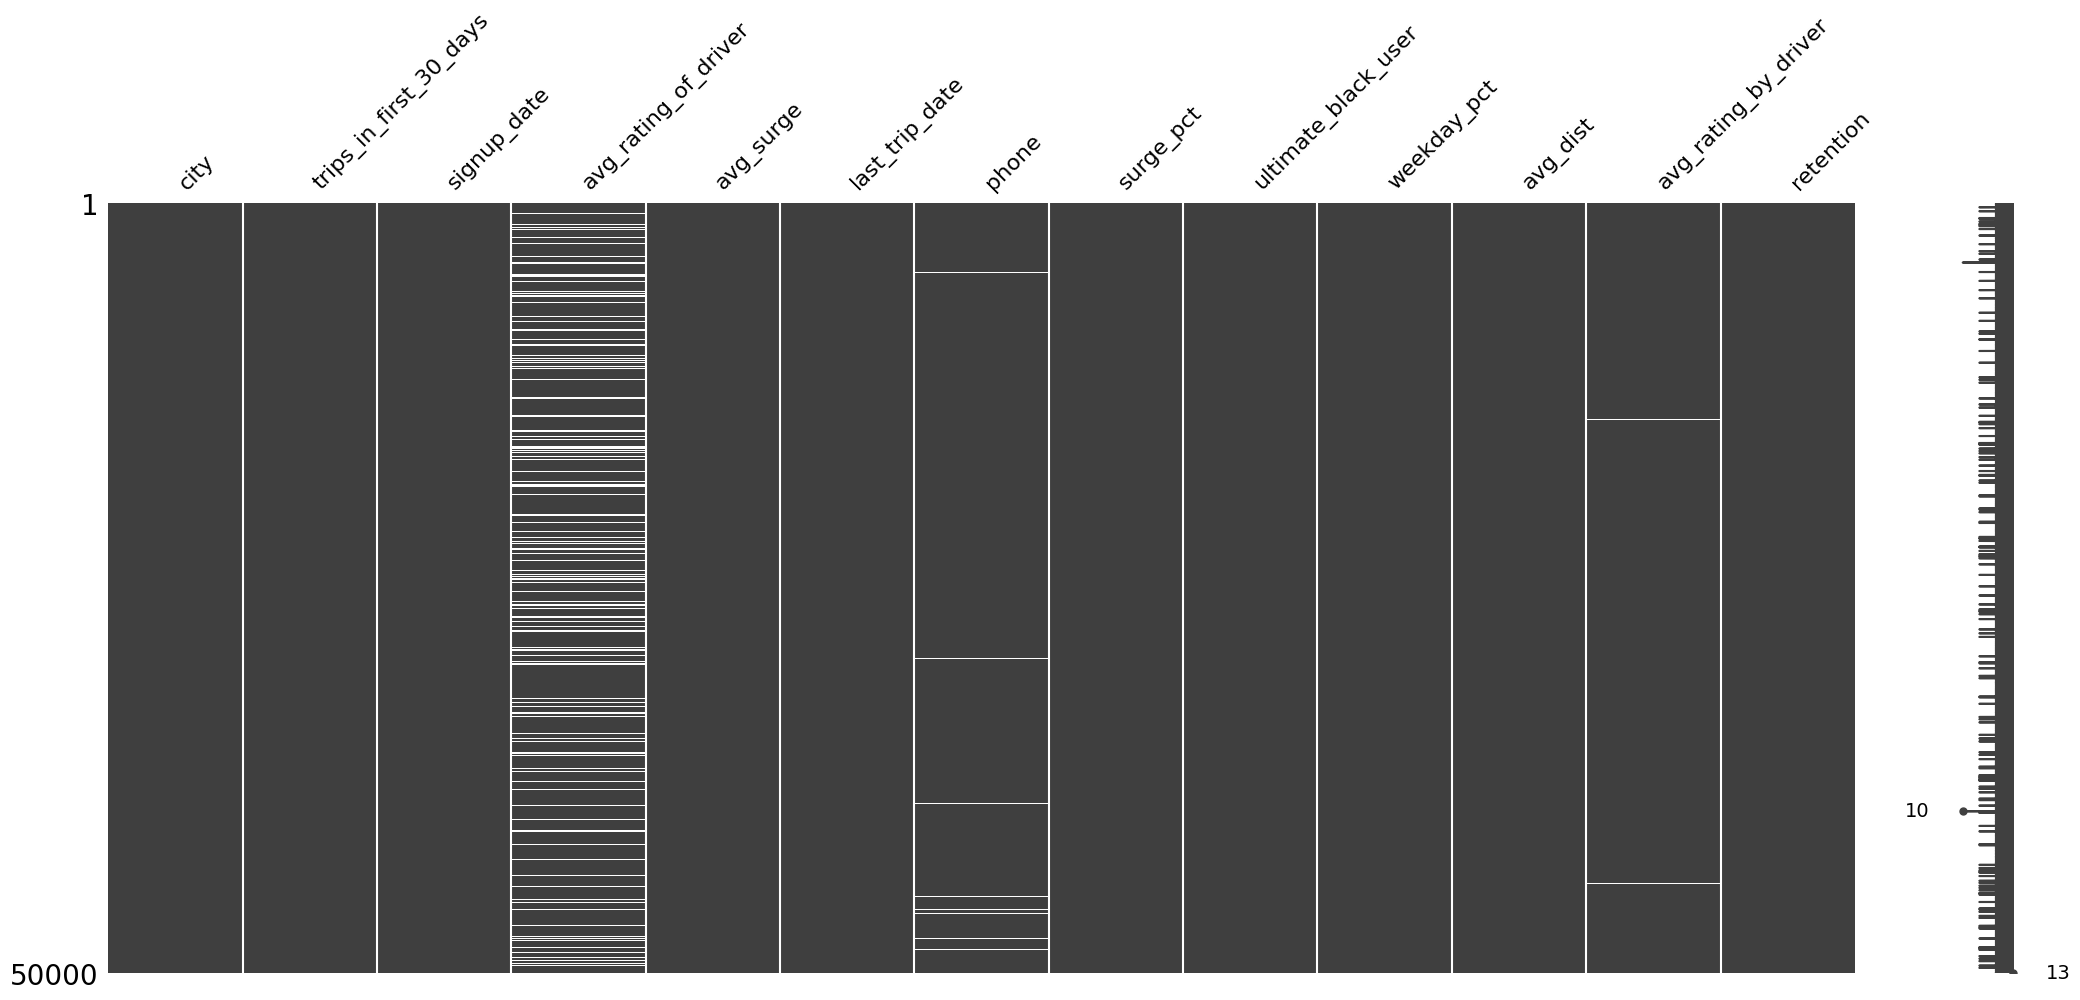

In [21]:
import missingno as msno
msno.matrix(user_df)
plt.show()

**There are only three features with missing values.**

/var/folders/4s/dkhgvddx5kb346fv_thq5bqh0000gn/T/ipykernel_18311/4143117996.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  user_df.corr()
/var/folders/4s/dkhgvddx5kb346fv_thq5bqh0000gn/T/ipykernel_18311/4143117996.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(user_df.corr())


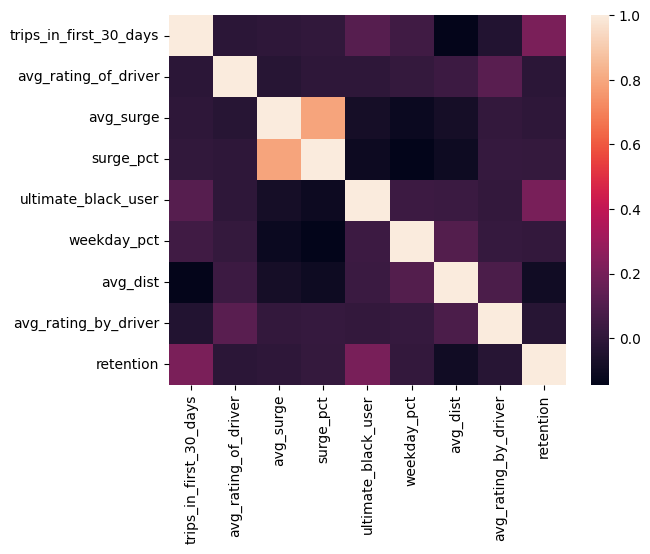

In [22]:
# Call the .corr() method on the dataset 
user_df.corr()

# Make a heatmap of the data 
_ = sns.heatmap(user_df.corr())
plt.show()

**It seems there is a moderate correlation between the retention and the other two features, trips_in_first_30_day and ultimate_black_user.**

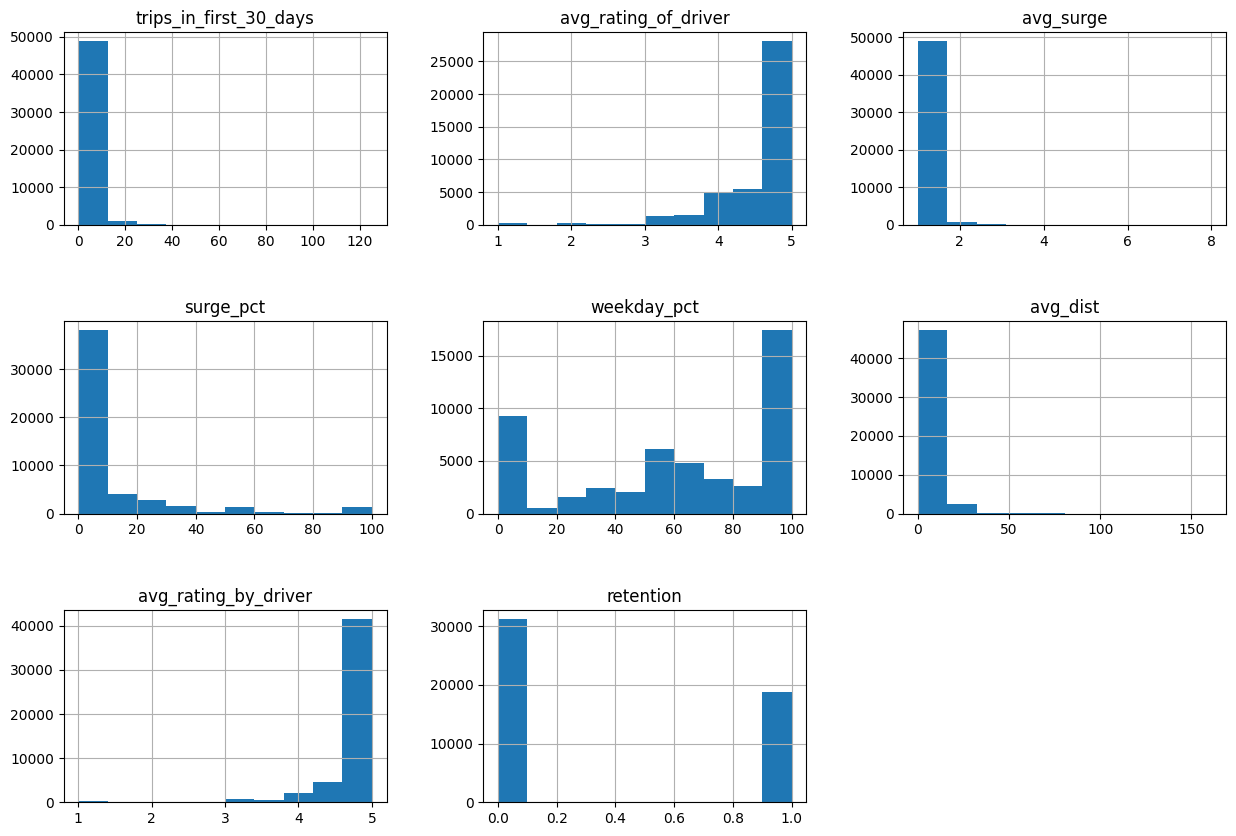

In [23]:
# Drop columns of datetime
user_df = user_df.drop(['signup_date','last_trip_date'], axis=1)

# Look into distributions of feature values
user_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

**The distribution of most feature variables is highly skewed and have a long right tail. Thus, we will perform a log transformation after imputation. Finally, we will scale our features since most of the models, besides tree-based models, are very sensitive to unscaled features.**

In [24]:
# Convert boolean variables to numeric
user_df['ultimate_black_user'].replace([True,False],[1, 0], inplace=True)

# Impute missing values in the phone column
import numpy as np
user_df['phone'].replace(np.nan,'other', inplace=True)

In [25]:
# Convert categorical variables to a one hot encoded Data Frame
one_hot_encoded = pd.get_dummies(user_df, columns=['city','phone'], prefix='OH')

# Move the ultimate_black_user column with the other one_hot_encoded columns
one_hot_encoded.insert(14, 'ultimate_black_user', one_hot_encoded.pop('ultimate_black_user'))

**Before we do any preprocessing to our data, we have to first split our data into training and test sets. To avoid data leakage, we will only train the pipeline of preprocessing on the train set, and keep the pipeline to apply it to the test set.**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Subsetting our data into our dependent and independent variables.
y = one_hot_encoded[['retention']]
X = one_hot_encoded.drop('retention', axis=1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,OH_Astapor,OH_King's Landing,OH_Winterfell,OH_Android,OH_iPhone,OH_other,ultimate_black_user
35624,1,5.0,1.00,0.0,0.0,3.92,5.0,0,0,1,0,1,0,1
14553,6,4.6,1.08,20.0,48.6,2.74,4.7,1,0,0,0,1,0,0
26802,0,5.0,1.00,0.0,20.0,4.48,5.0,0,1,0,0,1,0,0
8150,0,5.0,1.00,0.0,100.0,21.11,5.0,0,0,1,0,1,0,0
22469,1,5.0,1.00,0.0,100.0,1.65,5.0,0,0,1,1,0,0,1


In [27]:
# Instantiate an imputer
imputer = SimpleImputer(strategy='median')

# Instantiate a log transformer
pow_trans = PowerTransformer()

# Instantiate a scaler
scaler = StandardScaler()

# Build steps for the preprocessing pipeline
steps = [("imputer", imputer), 
         ("log_transform", pow_trans),
        ('standardization', scaler)]

# Set up pipeline
pipeline = Pipeline(steps)

# Apply fit_transform to numerical variables of X_train
X_train_num = pipeline.fit_transform(X_train.loc[:,'trips_in_first_30_days':'avg_rating_by_driver'])

# Apply transform to numerical variables of X_test
X_test_num = pipeline.transform(X_test.loc[:,'trips_in_first_30_days':'avg_rating_by_driver'])

In [28]:
# Recreate a DataFrame of the numeric features for X_train
X_train_num = pd.DataFrame(X_train_num, index=X_train.index, columns=X_train.columns[:7])

# Recreate a DataFrame of all the features (numerical + categorical) for X_train
X_train = pd.concat([X_train_num, X_train.loc[:,'OH_Astapor':'ultimate_black_user']], axis=1)
X_train.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,OH_Astapor,OH_King's Landing,OH_Winterfell,OH_Android,OH_iPhone,OH_other,ultimate_black_user
count,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-5.790923e-17,2.575717e-17,-6.394885e-18,-5.115908e-17,-1.350031e-17,-3.552714e-19,1.438849e-17,0.330500,0.203275,0.466225,0.300325,0.691650,0.008025,0.376075
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,0.470399,0.402440,0.498864,0.458405,0.461818,0.089223,0.484405
min,-1.270778e+00,-2.011238e+00,-6.109756e-01,-6.671169e-01,-1.773204e+00,-3.392653e+00,-2.146903e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.270778e+00,-8.918609e-01,-6.109756e-01,-6.671169e-01,-5.830428e-01,-6.807128e-01,-8.774243e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-5.791030e-02,3.867943e-01,-6.109756e-01,-6.671169e-01,2.489436e-01,-6.218825e-02,7.638100e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,8.395235e-01,8.666112e-01,6.199737e-01,1.363655e+00,9.714717e-01,6.754566e-01,7.638100e-01,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2.674249e+00,8.666112e-01,2.176227e+00,1.682780e+00,9.714717e-01,3.491547e+00,7.638100e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# Likewise, recreate a DataFrame of all the features (numerical + categorical) for X_test
X_test_num = pd.DataFrame(X_test_num, index=X_test.index, columns=X_test.columns[:7])
X_test = pd.concat([X_test_num, X_test.loc[:,'OH_Astapor':'ultimate_black_user']], axis=1)
X_test.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,OH_Astapor,OH_King's Landing,OH_Winterfell,OH_Android,OH_iPhone,OH_other,ultimate_black_user
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000918,-0.013308,0.009808,0.012415,-0.003702,0.000613,-0.004993,0.33140,0.199900,0.468700,0.300900,0.691600,0.007500,0.381100
std,1.006693,0.998897,1.003619,1.004226,0.999457,0.987155,1.000036,0.47074,0.399945,0.499044,0.458672,0.461856,0.086281,0.485681
min,-1.270778,-2.011238,-0.610976,-0.667117,-1.773204,-3.392653,-2.146903,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.270778,-0.891861,-0.610976,-0.667117,-0.583043,-0.675389,-0.877424,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.057910,0.386794,-0.610976,-0.667117,0.248944,-0.068909,0.763810,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.839523,0.866611,0.619974,1.382046,0.971472,0.684361,0.763810,1.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2.822611,0.866611,2.176227,1.682780,0.971472,2.812774,0.763810,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


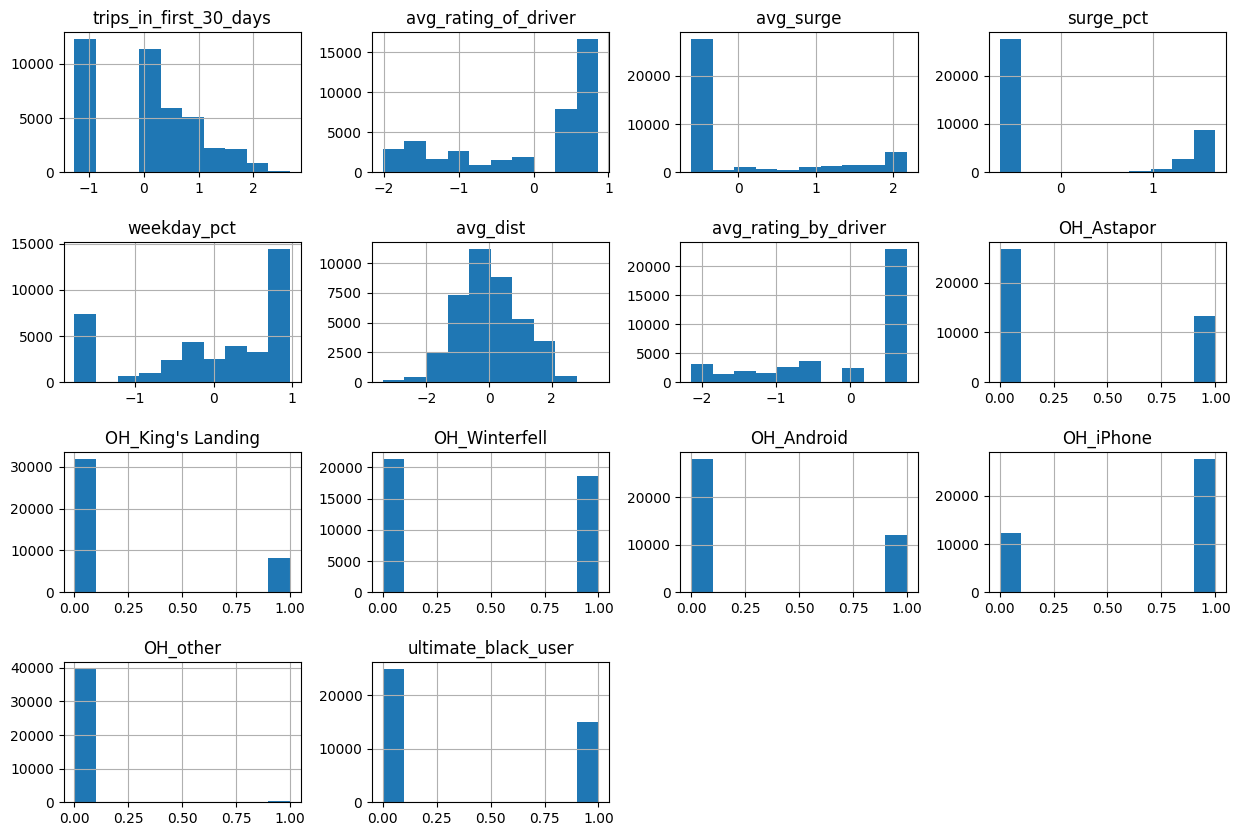

In [30]:
# Look into distributions of feature values after preprocessing
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

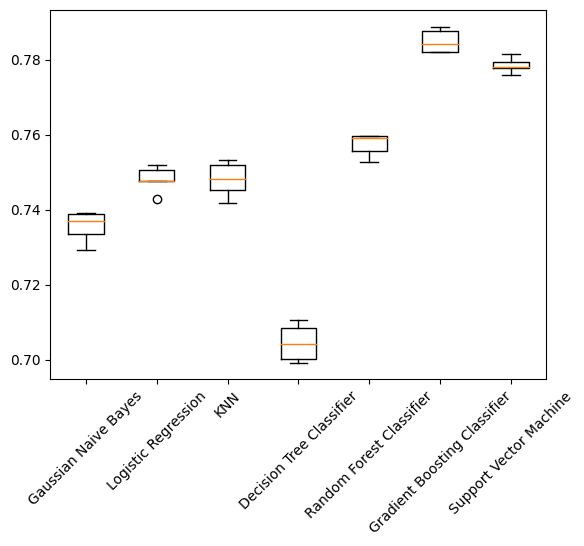

In [31]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Create models dictionary
models = {
    "Gaussian Naive Bayes": GaussianNB(), 
    "Logistic Regression": LogisticRegression(random_state=22), 
    "KNN": KNeighborsClassifier(), 
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=22),
    "Random Forest Classifier": RandomForestClassifier(random_state=22),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=22),
    "Support Vector Machine": SVC(random_state=22)
}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
  kf = KFold(n_splits=5, random_state=22, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

**This is a binary classificaiton problem. In our previous EDA, we learned that there is no strong correlation among most of our features. Thus, we first did a quick comparison for multiple classification models with default settings and investigated which one performs the best out of the box. Gradient Boosting Classifier (GBC) is clearly a winner with the highest accuracy score in this case.**

In [32]:
import time

# Gradient Boosting Classifier
# Create the parameter space
params = {'n_estimators': np.linspace(start = 1000, stop = 2000, num = 5, dtype=int),
          'learning_rate': [0.1, 0.25, 0.5],
          'max_depth': [4, 5, 6]}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the RandomizedSearchCV object
gbc_cv = RandomizedSearchCV(GradientBoostingClassifier(random_state=22), params, cv=kf, random_state=22)

start_time = time.time()

# Fit the data to the model
gbc_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_))
print("Tuned Gradient Boosting Best Accuracy Score: %.3f" % (gbc_cv.best_score_))

RandomizedSearchCV Run Time: 3588.710
Tuned Gradient Boosting Parameters: {'n_estimators': 1250, 'max_depth': 4, 'learning_rate': 0.1}
Tuned Gradient Boosting Best Accuracy Score: 0.788


In [33]:
# Gradient Boosting Classifier

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the Gradient Boosting Classifier model
gbc = GradientBoostingClassifier(n_estimators = 1250, 
                                 learning_rate = 0.1 , 
                                 max_depth = 4)

# Fit the data to the model
gbc.fit(X_train, y_train.values.ravel())

# Predict using the model
y_pred_gbc = gbc.predict(X_test)

Gradient Boosting: Accuracy=0.785
Gradient Boosting: f1-score=0.783
Gradient Boosting: log-loss=0.461
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      6239
         1.0       0.74      0.67      0.70      3761

    accuracy                           0.79     10000
   macro avg       0.77      0.76      0.77     10000
weighted avg       0.78      0.79      0.78     10000



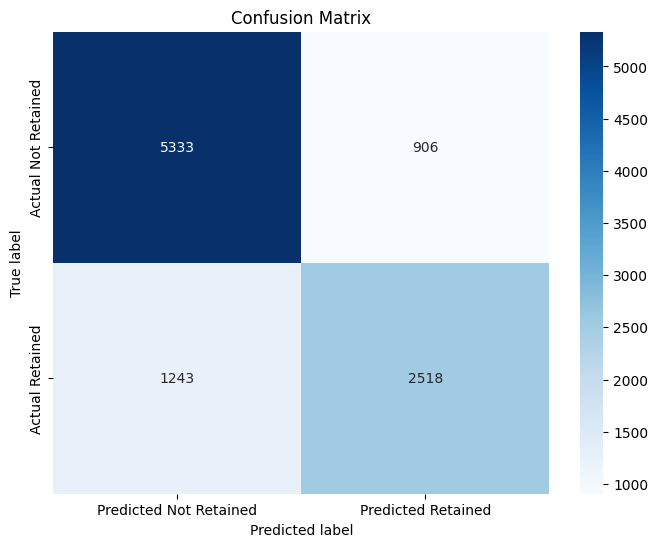

In [34]:
# Predict probabilities of each customer in the test being active (which is in the 2nd column of the output of .predict_proba)
y_pred_prob_gbc = gbc.predict_proba(X_test)
retention_prob_gbc = y_pred_prob_gbc[:,1]

ac_gbc = accuracy_score(y_test, y_pred_gbc)
f1_gbc = f1_score(y_test, y_pred_gbc, average='weighted')
ll_gbc = log_loss(y_test, y_pred_prob_gbc)
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
cr_gbc = classification_report(y_test, y_pred_gbc)

print('Gradient Boosting: Accuracy=%.3f' % (ac_gbc))
print('Gradient Boosting: f1-score=%.3f' % (f1_gbc))
print('Gradient Boosting: log-loss=%.3f' % (ll_gbc))
print(cr_gbc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbc, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Not Retained', 'Predicted Retained'], yticklabels=['Actual Not Retained', 'Actual Retained'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**After hyperparameter tuning, we can see that our GBC model indeed has a decent accuracy 79% and f1-score 83% for those non-retained customers. However, our model has a moderate f1-score 70% for indentifying retained drivers, which is partially attributed to the imbalanced dataset we have. Additionally, it takes much more time to optimize GBC comparing with other models.**

10


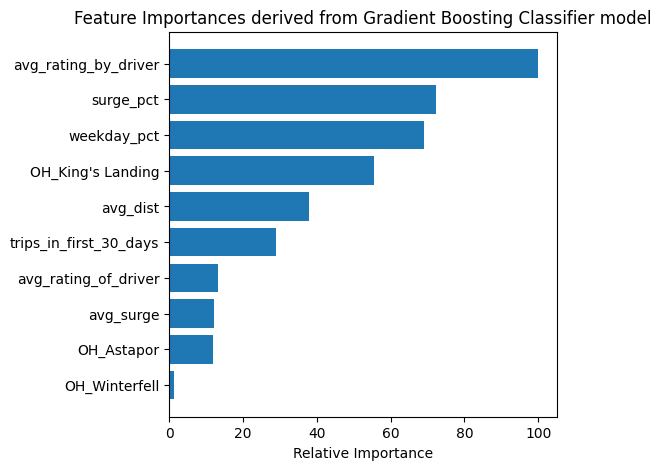

In [35]:
# Plot feature importances
feature_importance = gbc.feature_importances_

# Make importances relative to max importance
relative_importance = 100.0 * (feature_importance / feature_importance.max())[:10]
sorted_idx = np.argsort(relative_importance)[:10]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(5,5))
plt.barh(pos, relative_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importances derived from Gradient Boosting Classifier model',fontsize=12)
plt.show()

**After plotting the top 10 feature importances to gain a perspective on which features are driving the model predictions, we realized that avg_rating_by_driver, surge_pct, and weedkay_pct play an important role, suggesting that those active customers tend to be weekday riders during rush hours. In order to improve Ultimate's long term rider retention, I will suggest the company roll out promotions to allure new weekend riders and to retain loyal weekday commuters.**